In [1]:
# Python import
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings
import joblib
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import lightgbm as lgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

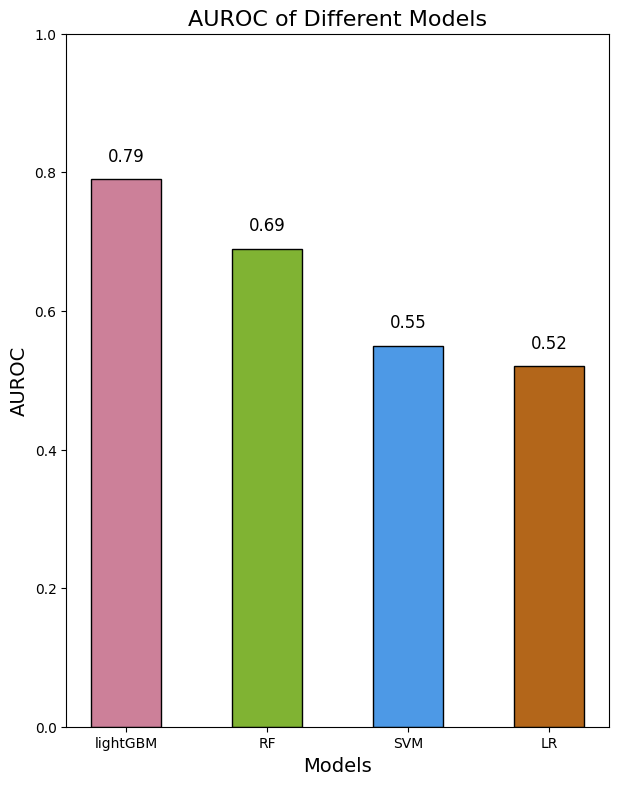

In [4]:
models = ['lightGBM', 'RF', 'SVM', 'LR']
auroc_values = [0.86, 0.69, 0.55, 0.75]


# colors = ['#D32F2F', '#FFEB3B', '#D500F9', '#66BB6A']
# colors = ['#4B9E4A', '#6BBF6D', '#99D79A', '#C4E7C6', '#E3F2E3', '#F5FBF5']
# colors = ['#DE66C2', '#5096DE', '#DEA13A', '#61DE45']
colors = [ (0.8, 0.5, 0.6), (0.5, 0.7, 0.2),  (0.3, 0.6, 0.9), (0.7, 0.4, 0.1)]

plt.figure(figsize=(7, 9))
bars = plt.bar(models, auroc_values, color=colors, width=0.5, edgecolor='black')
plt.ylim([0.0, 1.0])
# 添加 AUROC 值标签
for bar, value in zip(bars, auroc_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('AUROC of Different Models', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('AUROC', fontsize=14)

# 显示图像
plt.show()

In [ ]:
# Plot AUROC of multiple models
def plot_AUROC(LR_perf, SVM_perf, RF_perf, lightGBM_perf, path):
    # Prepare figure and line width
    plt.figure(figsize=(10, 10))
    lw = 2
    
    # Define colors with low saturation (RGB format)
    colors = {
        'LR': (0.7, 0.4, 0.1),  # RGB for LR (low saturation)
        'SVM': (0.3, 0.6, 0.9),  # RGB for SVM (low saturation)
        'RF': (0.5, 0.7, 0.2),   # RGB for RF (low saturation)
        'lightGBM': (0.8, 0.5, 0.6)  # RGB for lightGBM (low saturation)
    }
    
    # Function to plot a single model's AUROC
    def plot_single_roc(model_perf, label, color):
        roc_auc = model_perf["auroc"]
        fpr, tpr, _ = model_perf["auroc_curve"]
        plt.plot(fpr, tpr, color=color, lw=lw, label=f'{label} (AUROC = {roc_auc:.2f})')
    
    # Plot AUROC for each model
    plot_single_roc(LR_perf, 'LR', colors['LR'])
    plot_single_roc(SVM_perf, 'SVM', colors['SVM'])
    plot_single_roc(RF_perf, 'RF', colors['RF'])
    plot_single_roc(lightGBM_perf, 'lightGBM', colors['lightGBM'])
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC of Models")
    plt.legend(loc="lower right")
    
    # Save the plot
    plt.savefig(os.path.join(path, "AUROC_Models.pdf"), format="pdf")
    plt.show()


In [14]:
# Count the frequency of k-mer in each RNA sequence
# k-mer was normalized by total k-mer count of each RNA sequence
def _count_kmer(Dataset, k):  # k = 3, 4, 5
    
    # copy dataset
    dataset = copy.deepcopy(Dataset)
    # alphabet of nucleotide
    nucleotide = ['A', 'C', 'G', 'T']
    
    # generate k-mers
    #  k == 5:
    five = list(itertools.product(nucleotide, repeat=5))
    pentamer = [''.join(n) for n in five]
    
    #  k == 4:
    four = list(itertools.product(nucleotide, repeat=4))
    tetramer = [''.join(n) for n in four]

    # k == 3:
    three = list(itertools.product(nucleotide, repeat=3))
    threemer = [''.join(n) for n in three]
    
    # input features can be combinations of different k values
    if k == 34:
        table_kmer = dict.fromkeys(threemer, 0)
        table_kmer.update(dict.fromkeys(tetramer, 0))
    elif k == 45:
        table_kmer = dict.fromkeys(tetramer, 0)
        table_kmer.update(dict.fromkeys(pentamer, 0))
    elif k == 345:
        table_kmer = dict.fromkeys(threemer, 0)
        table_kmer.update(dict.fromkeys(tetramer, 0))
        table_kmer.update(dict.fromkeys(pentamer, 0))

    # count k-mer for each sequence
    for mer in table_kmer.keys():
        table_kmer[mer] = dataset["Sequence"].apply(lambda x: x.count(mer))
    
    # for k-mer raw count without normalization, index: nuc:1 or cyto:0
    rawcount_kmer_df = pd.DataFrame(table_kmer)
    df1_rawcount = pd.concat([rawcount_kmer_df, dataset["RNA_Symbol"]], axis=1)
    df1_rawcount.index = dataset["tag"]

    # for k-mer frequency with normalization, index: nuc:1 or cyto:0
    freq_kmer_df = rawcount_kmer_df.apply(lambda x: x / x.sum(), axis=1)
    df1 = pd.concat([freq_kmer_df, dataset["RNA_Symbol"]], axis=1)
    df1.index = dataset["tag"]

    return df1, df1_rawcount


In [ ]:
plot_AUROC(LR_perf, SVM_perf, RF_perf, lightGBM_perf, output_dir)

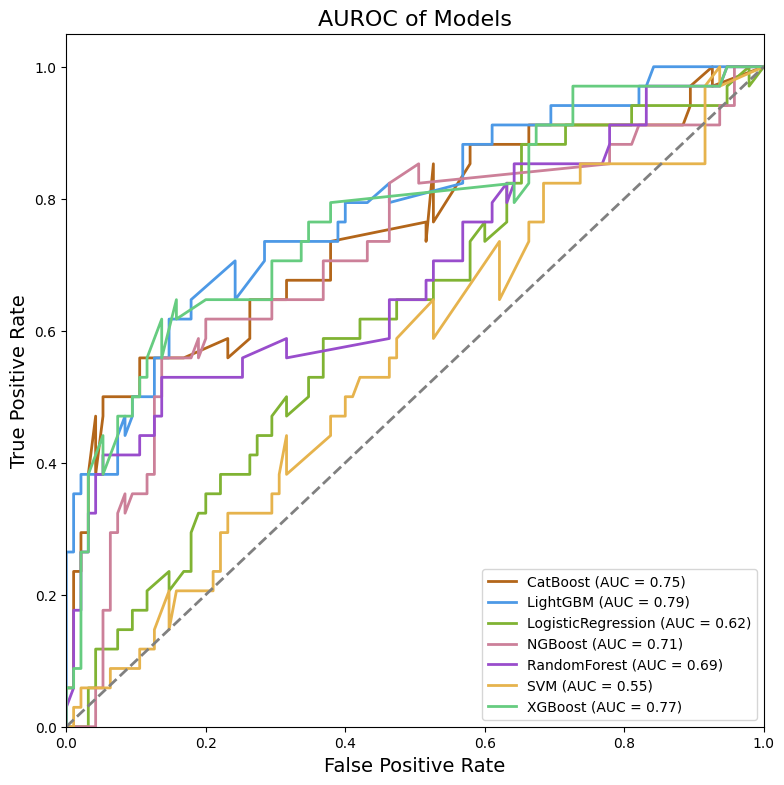

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_AUROC(main_path):
    # Prepare figure and line width
    plt.figure(figsize=(9, 9))
    lw = 2
    
    # Prepare 7 low-saturation colors in RGB format
    color_list = [
        (0.7, 0.4, 0.1),  # orange-ish
        (0.3, 0.6, 0.9),  # blue-ish
        (0.5, 0.7, 0.2),  # green-ish
        (0.8, 0.5, 0.6),  # pink-ish
        (0.6, 0.3, 0.8),  # purple-ish
        (0.9, 0.7, 0.3),  # yellow-ish
        (0.4, 0.8, 0.5)   # teal-ish
    ]
    
    # Get list of subfolders (model names), sort alphabetically for consistent color assignment
    subfolders = sorted([d for d in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, d))])
    
    # Limit to 7 models as specified
    if len(subfolders) > 7:
        subfolders = subfolders[:7]
        print("Warning: More than 7 subfolders found. Limiting to the first 7 (alphabetically sorted).")
    
    # Assign colors to models
    model_colors = {model: color_list[i] for i, model in enumerate(subfolders)}
    
    # Function to load data from file and compute AUROC
    def load_roc_data(file_path):
        df = pd.read_csv(file_path, sep='\t')
        fpr = df['FPR'].values
        tpr = df['TPR'].values
        # Ensure fpr is sorted ascending (though it should be)
        sorted_idx = np.argsort(fpr)
        fpr = fpr[sorted_idx]
        tpr = tpr[sorted_idx]
        # Compute AUC using trapezoidal rule
        roc_auc = np.trapz(tpr, fpr)
        return fpr, tpr, roc_auc
    
    # Function to plot a single model's AUROC
    def plot_single_roc(fpr, tpr, roc_auc, label, color):
        plt.plot(fpr, tpr, color=color, lw=lw, label=f'{label} (AUC = {roc_auc:.2f})')
    
    # Plot AUROC for each model
    for model in subfolders:
        file_path = os.path.join(main_path, model, 'AUROC_info.txt')
        if os.path.exists(file_path):
            fpr, tpr, roc_auc = load_roc_data(file_path)
            plot_single_roc(fpr, tpr, roc_auc, model, model_colors[model])
        else:
            print(f"Warning: File {file_path} not found. Skipping {model}.")
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("AUROC of Models", fontsize=16)
    plt.legend(loc="lower right")
    
    # Save the plot
    plt.savefig(os.path.join(main_path, "AUROC_Models.pdf"), format="pdf")
    plt.show()

# Example usage:
plot_AUROC('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/archived/circExor_archived_2025_5/models/saved_models/circRNA_ML_Model_Output')

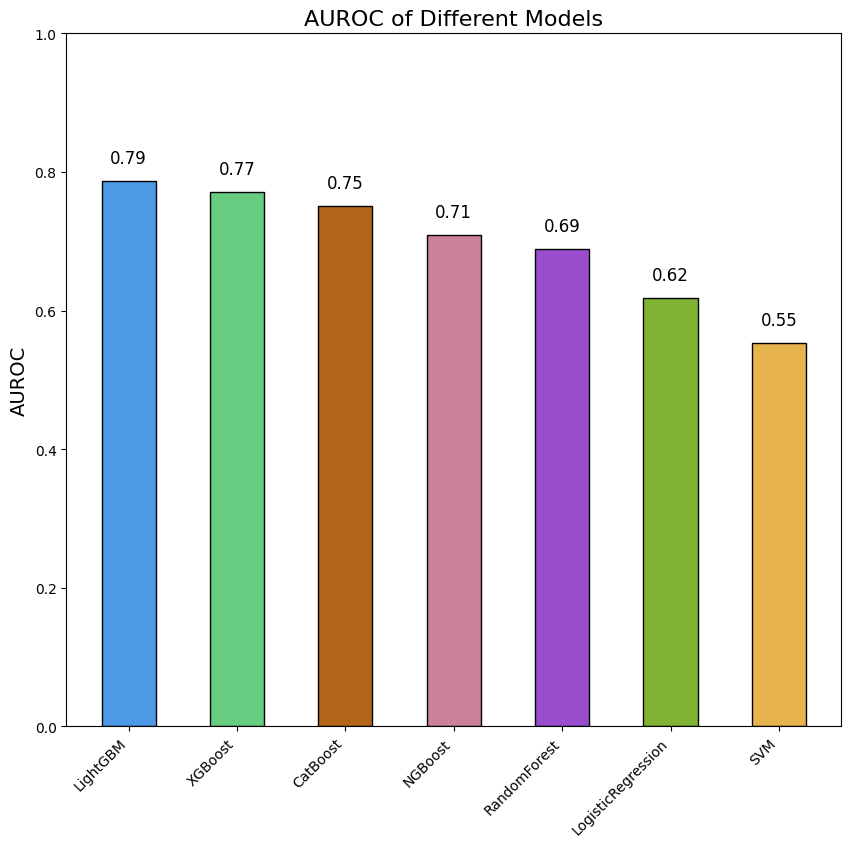

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_AUROC_bar(main_path):
    # Prepare figure
    plt.figure(figsize=(10, 9))  # Adjusted width for 7 models
    
    # Prepare 7 low-saturation colors in RGB format (unchanged)
    color_list = [
        (0.7, 0.4, 0.1),  # orange-ish
        (0.3, 0.6, 0.9),  # blue-ish
        (0.5, 0.7, 0.2),  # green-ish
        (0.8, 0.5, 0.6),  # pink-ish
        (0.6, 0.3, 0.8),  # purple-ish
        (0.9, 0.7, 0.3),  # yellow-ish
        (0.4, 0.8, 0.5)   # teal-ish
    ]
    
    # Get list of subfolders (model names), sort alphabetically for consistent color assignment
    subfolders = sorted([d for d in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, d))])
    
    # Limit to 7 models as specified
    if len(subfolders) > 7:
        subfolders = subfolders[:7]
        print("Warning: More than 7 subfolders found. Limiting to the first 7 (alphabetically sorted).")
    
    # Assign colors to models (fixed colors based on alphabetical order)
    model_colors = {model: color_list[i] for i, model in enumerate(subfolders)}
    
    # Function to load data from file and compute AUROC
    def load_roc_data(file_path):
        df = pd.read_csv(file_path, sep='\t')
        fpr = df['FPR'].values
        tpr = df['TPR'].values
        # Ensure fpr is sorted ascending (though it should be)
        sorted_idx = np.argsort(fpr)
        fpr = fpr[sorted_idx]
        tpr = tpr[sorted_idx]
        # Compute AUC using trapezoidal rule
        roc_auc = np.trapz(tpr, fpr)
        return roc_auc
    
    # Collect AUROC for each model
    model_auroc = {}
    for model in subfolders:
        file_path = os.path.join(main_path, model, 'AUROC_info.txt')
        if os.path.exists(file_path):
            roc_auc = load_roc_data(file_path)
            model_auroc[model] = roc_auc
        else:
            print(f"Warning: File {file_path} not found. Skipping {model}.")
    
    # Sort models by AUROC descending
    sorted_models = sorted(model_auroc.keys(), key=lambda m: model_auroc[m], reverse=True)
    sorted_auroc_values = [model_auroc[m] for m in sorted_models]
    sorted_colors = [model_colors[m] for m in sorted_models]
    
    # Plot the bar chart
    bars = plt.bar(sorted_models, sorted_auroc_values, color=sorted_colors, width=0.5, edgecolor='black')
    plt.ylim([0.0, 1.0])
    plt.xticks(rotation=45, ha='right')
    
    # Add AUROC value labels
    for bar, value in zip(bars, sorted_auroc_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12)
    
    plt.title('AUROC of Different Models', fontsize=16)
    # plt.xlabel('Models', fontsize=14)
    plt.ylabel('AUROC', fontsize=14)
    
    # Save the plot
    plt.savefig(os.path.join(main_path, "AUROC_Bar_Models.pdf"), format="pdf")
    
    # Display the plot
    plt.show()

# Example usage:
plot_AUROC_bar('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/archived/circExor_archived_2025_5/models/saved_models/circRNA_ML_Model_Output')